In [1]:
base_loc = '~/repos/ml-trial-room/mnist/'
dataset_loc = base_loc + 'MNIST_data/'

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from einops import rearrange, reduce
import matplotlib.pyplot as plt
import numpy as np

from autoencode import mnistPerceiverAutoencoder
from utils import get_mnist_dataset

In [20]:
MNIST_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
test_dataset = datasets.MNIST(root=dataset_loc, train=False, download=True, transform=MNIST_transform)

train_loader, val_loader, test_loader = get_mnist_dataset(dataset_loc=dataset_loc, batch_size=64, num_workers=4)

example: torch.Tensor = next(iter(train_loader))
num_classes: int = len(train_loader.dataset.dataset.classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# initialize model
model = mnistPerceiverAutoencoder(
    image_shape = example[0].shape[1:],
    num_classes = num_classes,
    num_frequency_bands = 12,
    latent_shape = (16, 16), 
    num_CA_blocks=2,
    num_SA_blocks=2,
    num_SA_layers=4,
    num_CA_out_heads=4,
    )
model.load_state_dict(torch.load('/home/nsk/repos/ml-trial-room/mnist/mnist_perceiver_autoencoder.pt'))
model.to(device)
pass

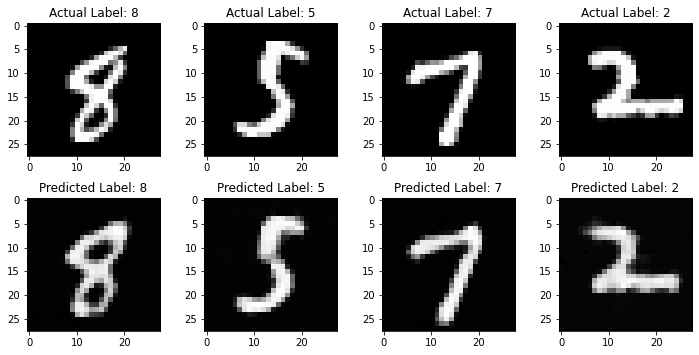

In [29]:
mean = 0.1307
std = 0.3081

# Get the first five images from the test dataset
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

# Pass the images through the model
with torch.no_grad():
    model.eval()
    recon_images, pred_labels = model(images)

# Invert the normalization transform
recon_images = (recon_images * std) + mean
pred_labels = pred_labels.argmax(dim=1)

images = rearrange(images, 'b c h w -> b h w c').cpu().numpy()
recon_images = rearrange(recon_images, 'b c h w -> b h w c').cpu().numpy()
# # Plot the original and reconstructed images and their actual and predicted labels
# fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
# for i, ax in enumerate(axes):
#     # Plot the original image
#     ax[0].imshow(images[i], cmap='gray')
#     ax[0].set_title(f'Actual Label: {labels[i].item()}')

#     # Plot the reconstructed image
#     ax[1].imshow(recon_images[i], cmap='gray')
#     ax[1].set_title(f'Predicted Label: {pred_labels[i]}')

# plt.tight_layout()
# plt.show()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i, ax in enumerate(zip(*axes)):
    ax[0].imshow(images[i], cmap='gray')
    ax[0].set_title(f'Actual Label: {labels[i].item()}')
    ax[1].imshow(recon_images[i], cmap='gray')
    ax[1].set_title(f'Predicted Label: {pred_labels[i]}')
plt.tight_layout()
plt.show()
